In [1]:
from sqlalchemy import create_engine
import pandas as pd

# Define connection parameters
db_params = {
    'dbname': 'Ecom_db',
    'user': 'postgres',
    'password': 'Aniket21*',
    'host': 'localhost',
    'port': '5432'
}

# Create the database connection string
conn_str = f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"

# Create an engine instance
engine = create_engine(conn_str)

# Query data
query = "SELECT * FROM orders;"
df = pd.read_sql(query, engine)

# Display the first 5 rows
print(df.head())


  invoiceno stockcode                          description  quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          invoicedate  unitprice  customerid         country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [2]:
# Convert InvoiceDate to datetime
df['invoicedate'] = pd.to_datetime(df['invoicedate'], format='%m/%d/%Y %H:%M', errors='coerce')

# Handle missing values, if any
df.dropna(inplace=True)  # Drop rows with any missing values


In [3]:
from sklearn.cluster import KMeans

# Aggregate data by CustomerID
customer_data = df.groupby('customerid').agg({
    'quantity': 'sum',
    'unitprice': 'mean'
}).reset_index()

# Define the number of clusters
n_clusters = 4  # Adjust as needed

# Create and fit K-means model with explicit n_init
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
customer_data['cluster'] = kmeans.fit_predict(customer_data[['quantity', 'unitprice']])

# View the clusters
print(customer_data[['customerid', 'cluster']].head())


   customerid  cluster
0     12346.0        0
1     12347.0        0
2     12348.0        0
3     12349.0        0
4     12350.0        0


In [4]:
# Aggregate sales by day
daily_sales = df.groupby(df['invoicedate'].dt.date).agg({
    'quantity': 'sum',
    'unitprice': 'mean'
}).reset_index()

# Create TotalSales column
daily_sales['totalsales'] = daily_sales['quantity'] * daily_sales['unitprice']

# Set the date as index
daily_sales.set_index('invoicedate', inplace=True)

# Set the frequency of the date index
daily_sales = daily_sales.asfreq('D')

In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Build and fit ARIMA model
model = ARIMA(daily_sales['totalsales'], order=(5, 1, 0))
model_fit = model.fit()

# Forecast future sales
forecast = model_fit.forecast(steps=30)


In [6]:
# Generate future dates
future_dates = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Create a forecast series with these future dates
forecast_series = pd.Series(forecast, index=future_dates)

# Print forecast results
print(forecast_series)


2011-12-10    68548.864669
2011-12-11    78581.304223
2011-12-12    74664.920565
2011-12-13    76410.629175
2011-12-14    64260.862449
2011-12-15    61852.289918
2011-12-16    69712.750555
2011-12-17    71389.301075
2011-12-18    71242.770980
2011-12-19    69852.879848
2011-12-20    67399.156775
2011-12-21    67882.824691
2011-12-22    69415.719700
2011-12-23    69798.161990
2011-12-24    69634.631898
2011-12-25    69056.276668
2011-12-26    68670.546000
2011-12-27    68924.982248
2011-12-28    69245.389894
2011-12-29    69314.625099
2011-12-30    69217.508221
2011-12-31    69061.699460
2012-01-01    69019.752528
2012-01-02    69100.742275
2012-01-03    69168.977929
2012-01-04    69173.460926
2012-01-05    69137.132052
2012-01-06    69102.779464
2012-01-07    69103.889074
2012-01-08    69126.328525
Freq: D, Name: predicted_mean, dtype: float64


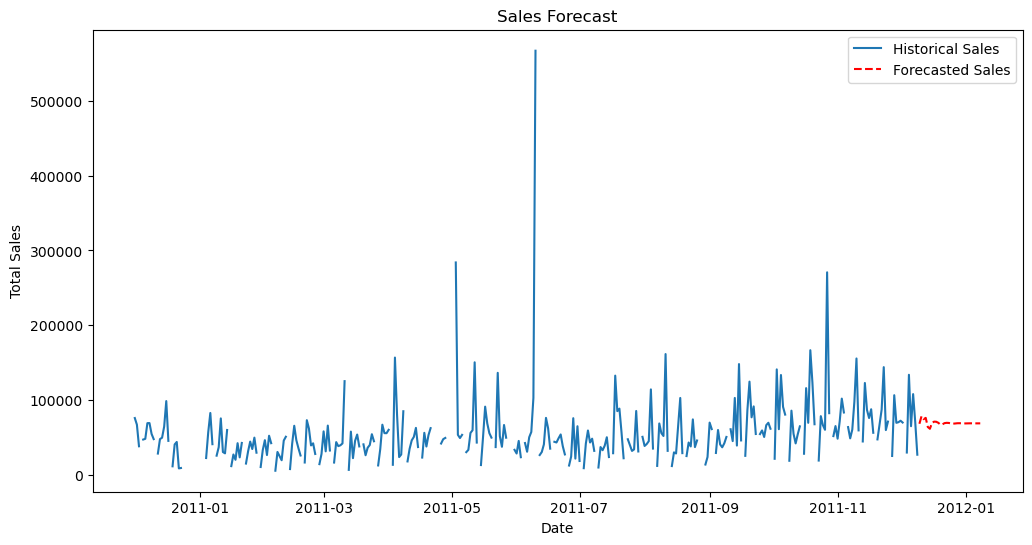

In [7]:
import matplotlib.pyplot as plt

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales['totalsales'], label='Historical Sales')

# Plot forecasted data
plt.plot(forecast_series.index, forecast_series, label='Forecasted Sales', linestyle='--', color='red')

plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()


In [8]:
# Export daily_sales to CSV
daily_sales.to_csv('daily_sales.csv')

# Export customer_data to CSV
customer_data.to_csv('customer_data.csv')


In [9]:
# Export forecast_series to CSV
forecast_series.to_csv('forecast_series.csv', header=['Forecasted Sales'])
